# SBU CSE 352 - HW 4 - Machine Learning From Scratch


All student names in group: Blake Lewinski, Liana Torpey

I understand that my submission needs to be my own group's work: B.C.L., L.G.T.

##### I understand that ChatGPT / Copilot / other AI tools are not allowed: B.C.L., L.G.T.
---

## Instructions

Total Points: 100

1. Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Only use standard packages (numpy and built-in packages like random). Submit the completely rendered notebook as a HTML file.

  **Important:** Do not use scikit-learn or other packages with ML built in. The point of this is to be a learning exercise. Using linear algebra from numpy is okay (things like matrix operations or pseudoinverse, for example, but not lstsq).

2. Your notebook needs to be formatted professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use matplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your PDF file is readable. For example, long lines are cut off in the PDF file. You don't have control over page breaks, so do not worry about these.
3. Document your code. Add a short discussion of how your implementation works and your design choices.

## Introduction

You will implement several machine learning algorithms and evaluate their accuracy. This will be done for a downscaled version of the MNIST digit recognition dataset.

**Like in real life, some of the tasks you will be asked to do may not be possible, at least directly. In these cases, your job is to figure out why it won't work and either propose a fix (best), or provide a clear explanation why it won't work.**

For example, if the problem says to do k-nearest neighbors with a dataset of a billion points, this could require too much time to do each classification so it's infeasible to evaluate its test accuracy. In this case, you could suggest randomly downsample the data to a more manageable size, which will speed things up by may lose some accuracy. In your answer, then, you should describe the problem and how you solved it and the trade-offs.

# Data
First the code below ensures you have access to the training data (a subset of the MNIST images), consisting of 100 handwritten images of each digit.

In [ ]:
# First download the repo and change the directory to be the one where the
# dependencies are. You should only need to do this once per session. If you
# want to reset, do Runtime -> Disconnect and Delete Runtime
# You can always do !pwd to see the current working directory and !ls to
# list current files.
!git clone https://github.com/stanleybak/CS7320-AI.git
%cd CS7320-AI/ML
!ls

Cloning into 'CS7320-AI'...
remote: Enumerating objects: 2738, done.
remote: Counting objects: 100% (855/855), done.
remote: Compressing objects: 100% (372/372), done.
remote: Total 2738 (delta 522), reused 796 (delta 478), pack-reused 1883
Receiving objects: 100% (2738/2738), 285.30 MiB | 14.23 MiB/s, done.
Resolving deltas: 100% (1690/1690), done.
Updating files: 100% (135/135), done.
/content/CS7320-AI/ML
line_fitting.ipynb	ML_example.ipynb	ML_for_tictactoe_self_play.ipynb  README.md
mini-mnist-1000.pickle	ML_for_tictactoe.ipynb	MNIST.ipynb


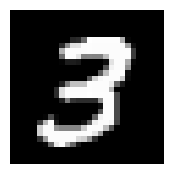

In [ ]:
import matplotlib.pyplot as plt
import pickle

# if the below fails to open, then the data file is not in the current working
# directory (see above code block)
with open('mini-mnist-1000.pickle', 'rb') as f:
  data = pickle.load(f)

im3 = data['images'][300] # 100 images of each digit
plt.figure(figsize=(2, 2))  # Adjust size as needed
plt.imshow(im3, cmap='gray')
plt.axis('off')
plt.show()

# Downscaling Images

MNIST images are originally 28x28. We will train our models not just on the original images, but also on downscaled images with the following sizes: 14x14, 7x7, 4x4, 2x2. The next code block shows one way to do downscaling. As you can tell from the output, we cannot expect our model's accuracy will be too high on lower resolution versions, although it's unclear how much better you can do than random chance, which should have a 10% accuracy.

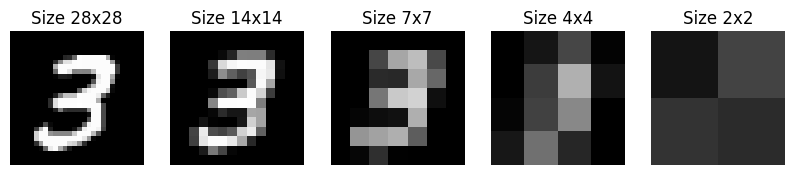

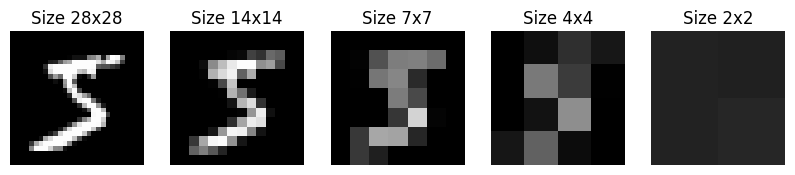

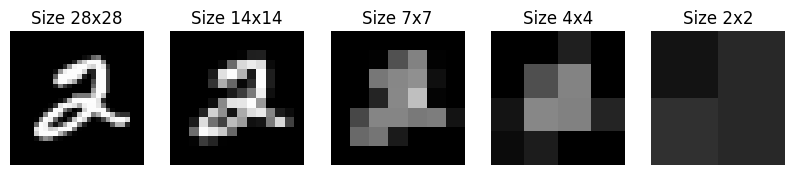

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Function to downscale an image to different sizes
def downscale_image(image, downscaled_size):
    block_size = 28 // downscaled_size
    downscaled = np.zeros((downscaled_size, downscaled_size))
    for i in range(downscaled_size):
        for j in range(downscaled_size):
            # Calculate the average for each block
            block = image[i*block_size:(i+1)*block_size,
                          j*block_size:(j+1)*block_size]
            downscaled[i, j] = np.mean(block)
    return downscaled

# Load the dataset (assuming this file is in your working directory)
with open('mini-mnist-1000.pickle', 'rb') as f:
    data = pickle.load(f)

images = data['images']  # a list of 1000 numpy image matrices
labels = data['labels']  # a list of 1000 integer labels

# Select 3 "random" indices from the dataset
random_indices = [300, 500, 200]

# Downscale the images to multiple sizes and display them
sizes = [28, 14, 7, 4, 2]
for index in random_indices:
    fig, axs = plt.subplots(1, len(sizes), figsize=(10, 2))
    for ax, size in zip(axs, sizes):
        downscaled_image = downscale_image(images[index], size)
        ax.imshow(downscaled_image, cmap='gray', vmin=0, vmax=255)
        ax.set_title(f'Size {size}x{size}')
        ax.axis('off')
    plt.show()

---
# Tasks

Your data contains 100 images in each class. When training models, use 80% of training, 10% for validation and 10% for testing. Make sure the data is balanced in each class when splitting.

---
## Task 1: Linear Classifier [20 points]

First, implement a linear classifier. The simplest way to do this is to adapt linear regression approaches that we learned about in class, where the output is a real number. For classification, we can let one category be an output of 1.0 and the other -1.0. Then, after the classifier is trained we can use the sign of the output to determine the predicted class.

However, since in MNIST there are multiple classes (10 digits, not just 2), we need to adapt the approach further. We will try both of the following two popular strategies: One-vs-Rest (OvR) and One-vs-One (OvO).

**One-vs-Rest (OvR)** is a strategy for using binary classification algorithms for multiclass problems. In this approach, a separate binary classifier is trained for each class, which predicts whether an instance belongs to that class or not, making it the 'one' against all other classes (the 'rest'). For a new input instance, compute the output of all classifiers. The predicted class is the one whose corresponding classifier gives the highest output value.

**One-vs-One (OvO)** is another strategy where a binary classifier is trained for every pair of classes. If there are N classes, you will train N(N−1)/2 classifiers. For a new input, evaluate it using all N(N−1)/2​ classifiers. Count the number of times each class is predicted over all binary classifications. The class with the highest count is selected as the final prediction.

### Report Results
Report the test accuracy for OvR and OvO, for each of the input image sizes, 28x28, 14x14, 7x7, 4x4, 2x2. A table may be helpful. Also report any interesting observations.

In [ ]:
import random
import math
import pickle
import pandas as pd
from copy import deepcopy
random.seed(10) # to make results repeatable

with open('mini-mnist-1000.pickle', 'rb') as f:
  data = pickle.load(f)

def data_split(data, size):
    """
    Split the data (by stratified splitting) into training, validation, and
    test sets.

    Parameters:
        data: A data set of images, represented as a dictionary.
        size: Size of images to be used for classification.

    Returns:
        training_set: 80% of original data set to be used for training.
        validation_set: 10% of original data set to be used for selecting
            hyperparameters.
        test_set: Last 10% of original data set to be used for testing
            models.
    """

    # use a tuple of images and labels rather than the data dictionary for
    # more efficient computations

    simplified_data = [(data['images'][i], data['labels'][i]) for i in
                       range(len(data['images']))]

    # separate the data by label classes for efficient stratified splitting
    class_zero = simplified_data[:100]
    class_one = simplified_data[100:200]
    class_two = simplified_data[200:300]
    class_three = simplified_data[300:400]
    class_four = simplified_data[400:500]
    class_five = simplified_data[500:600]
    class_six = simplified_data[600:700]
    class_seven = simplified_data[700:800]
    class_eight = simplified_data[800:900]
    class_nine = simplified_data[900:]
    classes = [class_zero, class_one, class_two, class_three,
            class_four, class_five, class_six, class_seven,
            class_eight, class_nine]

    # shuffle the classes to increase randomness amongst split sets
    for c in classes:
        random.shuffle(c)

    training_set = list()
    validation_set = list()
    test_set = list()

    # add 80% of each class to training set, 10% to validation set, and the
    # remaining 10% to the test set
    for c in classes:
        training_set = training_set + [(downscale_image(vector[0], size),
                                        vector[1]) for vector in c[:80]]
        validation_set = validation_set + [(downscale_image(vector[0],
                                            size), vector[1]) for vector in
                                            c[80:90]]
        test_set = test_set + [(downscale_image(vector[0], size),
                                vector[1]) for vector in c[90:]]

    return training_set, validation_set, test_set

def get_weight_vectors(train_matrix, labels):
    """
    Find the optimal weights vector for the binary classifier based on
    the input features matrix and their true class labels.

    Parameters:
        train_matrix: List of feature vectors for the training data to be used
            in finding optimal weights.
        labels: List of labels corresponding to the feature vectors.

    Returns:
        w: The optimal weights vector for predicting the class label for
            an input.
    """

    w = np.zeros(train_matrix.shape[1])

    for i in range(train_matrix.shape[0]):
        y_hat = w.dot(train_matrix[i])
        if y_hat >= 0:
            if labels[i] == -1:
                w -= train_matrix[i]
        else:
            if labels[i] == 1:
                w += train_matrix[i]
    return w

def make_predictions(test_matrix, weight_vectors):
    """
    Uses test data on generated binary classifiers to predict classification.

    Parameters:
        test_matrix: List of feature vectors for test data.
        weight_vectors: List of weight vectors, each corresponding to a binary
            classifier for a different class.

    Returns:
        final_y_hats: List of vectors of predicted labels, one list for each
            binary classifier.
    """

    final_y_hats = list()

    for test in test_matrix:

        # computes dot product of weights vector and features vector for
        # each binary classifier
        potential_preds = [weights.dot(test) for weights in weight_vectors]
        # chooses the label that produced the highest dot product value
        # as the prediction for this feature vector
        pred_label = np.where(potential_preds == np.max(potential_preds))[0][0]
        # add predicted label to list of all predictions for the test data
        final_y_hats.append(pred_label)

    return final_y_hats

def accuracy(pred_labels, true_labels):
    """
    Calculates accuracy of a binary classifier.

    Parameters:
        pred_labels: List of label predictions from some binary classifier.
        true_labels: List of the true labels for input data, the indices
            of pred_labels and true_labels corresponding to respective
            input images.

    Returns:
        float: Accuracy of predicted labels in comparison to true labels,
            represented as a float between 0 and 1.
    """
    num_correct = 0
    for pred_label, true_label in zip(pred_labels, true_labels):
        if pred_label == true_label:
            num_correct += 1
    return (num_correct / len(true_labels))

def one_vs_rest(data=data):
    """
    Performs the one-vs-rest approach of binary classification on a data set.

    Parameters:
        data: Data set of images represented as a dictionary.

    Returns:
        table: A list summarizing the results of binary classification
            by linear regression tactics based on image size, to be converted
            to a DataFrame for clean output as a table.
        data_sets: Dictionary of split data sets with corresponding image sizes
            so that both OVR and OVO can act on the same data sets.
    """
    sizes = [28, 14, 7, 4, 2]
    table = []
    data_sets = {}

    # perform binary classification on each designated image size

    for s in sizes:

        # split the data
        training_set, validation_set, test_set = data_split(data, s)

        # save this data set in a dictionary so we can use it again in
        # the one_vs_one approach

        data_sets[s] = (deepcopy(training_set), deepcopy(validation_set),
                        deepcopy(test_set))

        # shuffle each set one last time
        random.shuffle(training_set)
        random.shuffle(validation_set)
        random.shuffle(test_set)

        # separate the feature vectors and class labels
        train_feat = np.array([t[0].flatten() for t in training_set])
        train_labels = np.array([t[1] for t in training_set])
        val_feat = np.array([t[0].flatten() for t in validation_set])
        val_labels = np.array([t[1] for t in validation_set])
        test_feat = np.array([t[0].flatten() for t in test_set])
        test_labels = np.array([t[1] for t in test_set])

        # No hyperparameters need to be explored for linear regression, so we'll
        # remerge the training and validation sets before starting training.
        merged_features = np.append(train_feat, val_feat, axis=0)
        merged_labels = np.append(train_labels, val_labels, axis=0)

        # creating label vectors for each class to be used in their
        # binary classifiers
        y_zero = np.array([1 if label == 0 else -1 for label in merged_labels])
        y_one = np.array([1 if label == 1 else -1 for label in merged_labels])
        y_two = np.array([1 if label == 2 else -1 for label in merged_labels])
        y_three = np.array([1 if label == 3 else -1 for label in merged_labels])
        y_four = np.array([1 if label == 4 else -1 for label in merged_labels])
        y_five = np.array([1 if label == 5 else -1 for label in merged_labels])
        y_six = np.array([1 if label == 6 else -1 for label in merged_labels])
        y_seven = np.array([1 if label == 7 else -1 for label in merged_labels])
        y_eight = np.array([1 if label == 8 else -1 for label in merged_labels])
        y_nine = np.array([1 if label == 9 else -1 for label in merged_labels])
        label_vectors = [y_zero, y_one, y_two, y_three, y_four, y_five, y_six,
                         y_seven, y_eight, y_nine]

        # get optimal weight vectors for each binary classifier
        all_weights = [get_weight_vectors(merged_features, labels) for
                       labels in label_vectors]
        # weights = get_weight_vectors(merged_features, label_vectors)
        # test these weight vectors by making predictions for the test data
        y_hats = make_predictions(test_feat, all_weights)
        # calculate accuracy of these predictions
        test_accuracy = accuracy(y_hats, test_labels)
        # add results to table
        table.append({
            "Approach": "One-VS-Rest",
            "Image Size": f"{s}x{s}",
            "Test Accuracy": "{:0.2f}%".format(test_accuracy*100)
        })

    return table, data_sets

def make_predictions_OVO(test_data, weights_dict):
    """
     Uses test data on generated binary classifiers to predict classification,
     following different process for the one-versus-one approach.

    Parameters:
        test_matrix: List of feature vectors for test data.
        weights_dict: Dictionary of weight vectors with corresponding tuples
            of the two classes on which the weight vector was based.

    Returns:
        predictions: List of vectors of predicted labels, one list for each
            binary classifier.
    """
    predictions = list()
    for t in test_data:
        # keep count of how many times each class is predicted
        counts = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
        for classes, vector in zip(weights_dict.keys(), weights_dict.values()):
            output = vector.dot(t)
            if output > 0:
                pred = classes[0]
            else:
                pred = classes[1]
            counts[pred] += 1
        # choose the class that was predicted the most as the final prediction
        # for this feature vector
        predictions.append(max(counts, key=counts.get))
    return predictions

def one_vs_one(data_sets):
    """
    Performs the one-vs-one approach of binary classification on given
    data sets.

    Parameters:
        data_sets: Dictionary of pre-split data sets that were created
        during the One-Versus-Rest approach (to keep data as consistent
        as possible between the two approaches so we can compare them).

    Returns:
        table: A list summarizing the results of binary classification
            by linear regression tactics based on image size, to be converted
            to a DataFrame for clean output as a table.
    """
    table = []

    # iterate over the sizes and corresponding data sets of each previously
    # generated set from the already-run OVR approach
    for size, data_set in zip(data_sets.keys(), data_sets.values()):

        training_data, validation_data, test_data = data_set

        # the training and validation sets are merged together given there
        # are no hyperparameters to explore; we then separate them
        # by class for one-vs-one implementation
        class_zero = training_data[:80] + validation_data[:10]
        class_one = training_data[80:160] + validation_data[10:20]
        class_two = training_data[160:240] + validation_data[20:30]
        class_three = training_data[240:320] + validation_data[30:40]
        class_four = training_data[320:400] + validation_data[40:50]
        class_five = training_data[400:480] + validation_data[50:60]
        class_six = training_data[480:560] + validation_data[60:70]
        class_seven = training_data[560:640] + validation_data[70:80]
        class_eight = training_data[640:720] + validation_data[80:90]
        class_nine = training_data[720:] + validation_data[90:]
        classes = [class_zero, class_one, class_two, class_three,
                    class_four, class_five, class_six, class_seven,
                    class_eight, class_nine]

        data_sets = list()

        # we need to generate classifiers for every pair of datasets, so we
        # create training sets by merging every possible pair of datasets

        for i in range(9):
            for j in range(i+1, 10):
                data_sets.append(classes[i] + classes[j])

        # will store optimal weight vectors from each classifier in a
        # dictionary, where the vectors are the values and the keys are tuples
        # where the first element is the class of the "positive" label for
        # that weight vector's corresponding classifier and the second element
        # is the class of the "negative" label
        weights_dict = {}


        # iterate over every data set to produce the weight vectors for each
        # classifier
        for data_set in data_sets:
            # retain what classes are being treated as the positive and
            # negative labels for this classifer
            pos_label = data_set[0][1]
            neg_label = data_set[-1][1]

            # shuffle the training set for randomness in weight optimization
            # function
            random.shuffle(data_set)

            # split the data set into feature and label vectors, then create
            # a new label vector that makes all the pos_label labels 1, and
            # all the neg_label labels -1
            features = np.array([e[0].flatten() for e in data_set])
            labels = np.array([e[1] for e in data_set])
            true_labels = np.array([1 if label == pos_label else -1 for label
                                    in labels])

            # find the optimal weight vector and add it to the dictionary
            # along with the positive and negative class labels
            weight_vector = get_weight_vectors(features, true_labels)
            weights_dict[(pos_label, neg_label)] = weight_vector

        # shuffle the test set before testing
        random.shuffle(test_data)
        # split into feature and label vectors
        test_features = np.array([e[0].flatten() for e in test_data])
        test_labels = np.array([e[1] for e in test_data])
        # make predictions for each instance in the test set
        final_predictions = make_predictions_OVO(test_features, weights_dict)
        # record accuracy
        test_accuracy = accuracy(final_predictions, test_labels)
        # add results to table
        table.append({
            "Approach": "One-VS-One",
            "Image Size": f"{size}x{size}",
            "Test Accuracy": "{:0.2f}%".format(test_accuracy*100)
        })
    return table

table_OVR, split_sets = one_vs_rest()
table_OVO = one_vs_one(split_sets)
full_table = pd.concat([pd.DataFrame(table_OVR), pd.DataFrame(table_OVO)],
                       ignore_index=True, sort=False)
print(full_table.to_string(index=False))

   Approach Image Size Test Accuracy
One-VS-Rest      28x28        78.00%
One-VS-Rest      14x14        74.00%
One-VS-Rest        7x7        67.00%
One-VS-Rest        4x4        57.00%
One-VS-Rest        2x2        27.00%
 One-VS-One      28x28        73.00%
 One-VS-One      14x14        80.00%
 One-VS-One        7x7        78.00%
 One-VS-One        4x4        61.00%
 One-VS-One        2x2        20.00%


Some interesting trends were noted after running the linear regression classifier for multiple random seeds. Firstly, both the OVR and OVO approaches had very similar accuracies - neither approach seemed to have a greater performance than the other. It was observed that the 28x28, 14x14, and 7x7 image sizes consistently had the best test accuracy in comparison to 4x4 and 2x2, which makes sense considering that they have more features and thus more information to be used in classification. However, by the same token, classification by linear regression performs better on input of lower dimensions, so 28x28 often performed equally as well if not slightly worse than 14x14 and 7x7. It can be concluded that there's some balance between lots of features and not-too-high dimensions that come into play in order for classification by linear regression/binary perceptron to perform well.

---
## Task 2: Data Augmentation [20 points]

Your boss was unhappy with the test accuracy, especially of your 2x2 image classifier, and has made some suggestions. The problem, according to your boss, is that there is not enough data in each input $x$. You are told to augment the data with derived features in order to help the classifier.

Specifically, given an input $x$, create additional attributes by computing all of the data up to powers of two. For example, in the 2x2 case your example $x$ consists of four pixel values $x_0$, $x_1$, $x_2$, and $x_3$. Your new input data would have:

* all power of zero: 1 (constant)
* all powers of one: $x_0$, $x_1$, $x_2$, $x_3$
* all powers of two:

  $x_0^2$, $x_0 x_1$, $x_0 x_2$, $x_0 x_3$,
  
  $x_1^2$, $x_1 x_2$, $ x_1 x_3$,
  
  $x_2^2$, $x_2 x_3$,
  
  $x_3^2$

The data would have 15 values, which has the potential to learn nonlinear relationships between the original inputs, which was not possible before.

### Report Results

Report the test accuracy for OvR only, with the data augmentation approach, for each of the input image sizes, 28x28, 14x14, 7x7, 4x4, 2x2 (again, perhaps incorporating a table). Report any interesting results or observations.

Also, explain to your boss what the danger is of looking at a model's final test accuracy and then suggesting changes to improve it. What should be done instead, if you know you will consider different types of models or hyperparameters in the same model class?

We did not include 28x28 in our data augmentation methods, which we will explain below the code block.

In [ ]:
import random
import pickle
import pandas as pd
random.seed(20)

with open('mini-mnist-1000.pickle', 'rb') as f:
  data = pickle.load(f)

def augment_features(vector):
    """
    Augments the data of the input vector by generating a new one that consists
    of all the data up to powers of two.

    Parameters:
        vector: Original features vector

    Returns:
        aug_vector: new features vector of augmented data. For original vector
            of length n, aug_vector will have a length of n(n+1)/2 + n + 1.
    """
    # start augmented data vector with data powered to 0 (1, always true)
    aug_vector = np.ones(1)
    # add all the data to powers of one (original vector)
    aug_vector = np.concatenate((aug_vector, vector))
    length = len(aug_vector)
    # add all the data to powers of two
    for i in range(1, length):
        for j in range(i, length):
            aug_vector = np.append(aug_vector, aug_vector[i] * aug_vector[j])

    return aug_vector

def augmented_OVR(data=data):
    """
    Alternate One-vs-Rest multiclass classifier that first augments the data
    in the feature vectors.

    Parameters:
        data_sets: Dictionary of pre-split data sets that were created
        during the One-Versus-Rest approach (to keep data as consistent
        as possible between the two approaches so we can compare them).

    Returns:
        table: A list summarizing the results of binary classification
            by linear regression tactics based on image size, to be converted
            to a DataFrame for clean output as a table.
    """
    sizes = [14, 7, 4, 2]
    table = []

    # perform classification on each image size

    for s in sizes:

        # split the data
        train_set, valid_set, test_set = data_split(data, s)

        # shuffle each data set one last time
        random.shuffle(train_set)
        random.shuffle(valid_set)
        random.shuffle(test_set)


        # split the data into feature vectors and labels
        train_feat = np.array([t[0].flatten() for t in train_set])
        train_labels = np.array([t[1] for t in train_set])
        val_feat = np.array([t[0].flatten() for t in valid_set])
        val_labels = np.array([t[1] for t in valid_set])
        test_feat = np.array([t[0].flatten() for t in test_set])
        test_labels = np.array([t[1] for t in test_set])

        # since there are no hyperparameters to explore for linear regression,
        # we remerge the training and validation sets to use for training,
        # while also augmenting the features of the training and test sets
        merged_features = np.append(train_feat, val_feat, axis=0)
        merged_features = np.array([augment_features(t) for t in
                                    merged_features])
        test_feat = np.array([augment_features(t) for t in test_feat])
        merged_labels = np.append(train_labels, val_labels, axis=0)

        y_zero = np.array([1 if label == 0 else -1 for label in merged_labels])
        y_one = np.array([1 if label == 1 else -1 for label in merged_labels])
        y_two = np.array([1 if label == 2 else -1 for label in merged_labels])
        y_three = np.array([1 if label == 3 else -1 for label in merged_labels])
        y_four = np.array([1 if label == 4 else -1 for label in merged_labels])
        y_five = np.array([1 if label == 5 else -1 for label in merged_labels])
        y_six = np.array([1 if label == 6 else -1 for label in merged_labels])
        y_seven = np.array([1 if label == 7 else -1 for label in merged_labels])
        y_eight = np.array([1 if label == 8 else -1 for label in merged_labels])
        y_nine = np.array([1 if label == 9 else -1 for label in merged_labels])
        label_vectors = [y_zero, y_one, y_two, y_three, y_four, y_five, y_six,
                         y_seven, y_eight, y_nine]

        # get optimal weight vectors for each class' binary classifier
        all_weights = [get_weight_vectors(merged_features, labels) for labels
                       in label_vectors]

        # test these weight vectors by making predictions for the test data
        y_hats = make_predictions(test_feat, all_weights)

        # calculate accuracy of these predictions
        test_accuracy = accuracy(y_hats, test_labels)

        # add results to the table
        table.append({
            "Image Size": f"{s}x{s}",
            "Test Accuracy": "{:0.2f}%".format(test_accuracy*100)
        })

    return table

t = augmented_OVR()
print(pd.DataFrame(t).to_string(index=False))

Image Size Test Accuracy
     14x14        89.00%
       7x7        81.00%
       4x4        48.00%
       2x2        11.00%


Similarly to our first attempts at classification in task 1, we can see that greater image sizes came with a higher test accuracy, as expected. 14x14 specifically seemed to perform slightly better with data augmentation, although generally the performances did not improve much (although they did not worsen either - performance was about the same overall).

We left 28x28 out of our analysis. Using data augmentation, feature vectors would require the model to have **308,505** parameters. This clearly not only leads to extreme overfitting, but the run time became abysmal. The 14x14 image size already had a run time of several minutes with only 19,503 parameters, so attempting to create a model with nearly **16 times** as many parameters would exponentially increase runtime.

As stated previously, this type of classification does not perform as well in higher dimensions. Although the added features provided much information about the relationship between elements of the input, it is still increasing the number of parameters by quite a bit. So, again, there is a balance between the two that it appears 14x14 achieves quite well. However, as explained in the previous paragraph, 28x28 is simply too high-dimensional.

Using test accuracy to measure model performance should not be practiced because this then means that you are using the test data to make decisions about the model, while test data should only be used as unseen data to analyze the generalization prowess of the model. If one knows that they are going to consider multiple models or multiple hyperparameters within a model, the user should implement **validation data** in a training-validation-test split. Create different models solely using the training data, then run them on the validation data to determine which one is best. From there, you can see how it generalizes using the test data and test accuracy.

---
## Task 3: k-Nearest Neighbors Classifier [20 points]

Your boss is still unhappy with the results (and still ignoring your advice about not using test data accuracy for model decisions).

Next, you are to use the k-nearest neighbors approach to build a classifier for our data. Since we have multiple classes, the one that gets selected can be based on a plurality vote of the $k$ closest samples (whichever category is most frequent). If there are ties, select the class based on the sum of the distances from the test point. For example, if $k=5$, and the closest 5 samples have two pictures that are from category "1" and two pictures that are from category "7", then you choose the output by computing the sum of the distance from the test point and the two "5" samples, as well as the sum of distances from the test point to the two "7" samples, and then outputting the class with the smaller total distance.

### Report Results

For each image size, exhaustively explore different values of $k$ up to 50. Report the best test accuracy. Report the average time taken to do a lookup with the model.

In [ ]:
import pickle
import random
import time
random.seed(0)

with open('mini-mnist-1000.pickle', 'rb') as f:
  data = pickle.load(f)

def euclid_dist(vec_1, vec_2):
    """
    We used euclidean distance to measure distance between
    vectors for the nearest neighbor computations.

    Parameters:
        vec_1: The first vector to be considered.
        vec_2: The second vector of which the euclidean distance
            between itself and vec_1 will be calculated.

    Returns:
        float: The euclidean distance between vec_1 and vec_2.
    """
    dist = 0

    for feat_1, feat_2 in zip(vec_1, vec_2):
        dist += (feat_1 - feat_2)**2

    return dist**0.5

def make_prediction_KNN(dist_dict):
    """
    Takes in a dictionary of the nearest neighbors for some vector,
    and returns the label that appears the most between the neighbors
    (returning the label with the shortest total distance from the test
    point if there are ties).

    Parameters:
        dist_dict: Dictionary of previously determined nearest neighbors,
            which has the distances as keys and their respective class labels
            as the values.
    """
    # keep track of how many times each class appears in the dictionary
    # of previously determined nearest neighbors
    counts = {
        0:0,
        1:0,
        2:0,
        3:0,
        4:0,
        5:0,
        6:0,
        7:0,
        8:0,
        9:0
    }

    # increments classes that appear in nearest neighbors dictionary
    for label in dist_dict.values():
        counts[label] += 1

    # place holder variables to help with determining most frequent
    # label and presence of ties
    tie_flag = False
    ties = list()
    max = 0
    max_label = 0

    for c in counts.keys():

        # found a label more occurrent than the current most-occurrent label
        if counts[c] > max:
            max = counts[c]
            # keep track is currently most occurrent for breaking ties if
            # needed
            max_label = c
            # if the previously most occurrent label was a tie, we can
            # ignore that now that we've found a more occurrent label
            if tie_flag:
                tie_flag = False

        # if we found a tie with the current most occurrent label (ignores
        # 0, as this is what we initialize the placeholder variable as)
        elif counts[c] == max and counts[c] != 0:
            tie_flag = True
            # store the two labels that tied in a tuple for tie-breaking
            ties.append(max_label)
            ties.append(c)

    # if there were no ties, return the most occurrent label
    if not tie_flag:
        return max_label

    # if a tie occurred
    else:

        sum_1 = 0
        sum_2 = 0

        # calculate the total sum of the distances of neighbors with
        # each of the class labels that tied
        for key in dist_dict.keys():
            if dist_dict[key] == ties[0]:
                sum_1 += key
            elif dist_dict[key] == ties[1]:
                sum_2 += key

        # return the label with the lowest sum
        return ties[0] if sum_1 < sum_2 else ties[1]

def lookup(data, data_labels, lookup_data, lookup_labels, k):
    """
    Function that runs the table lookup over the whole data set
    and returns the accuracy, along with the total time taken
    for all lookups.

    Parameters:
        data: Set of feature vectors to be predicted for.
        data_labels: True classes of the input feature vectors.
        lookup_data: Training data that is used in lookup table construction.
        lookup_labels: True classes of the training data.
        k: Number of nearest neighbors to be determined.
    """

    total_time = 0
    correct = 0

    # iterate over every feature vector in the input data
    for i in range(len(data)):
        d = data[i]
        # will store the distances from every training data vector
        # to the test point in a dictionary, with the distances as keys
        # and the training vector's true class label as the value
        distances = {}
        for t, l in zip(lookup_data, lookup_labels):
            distances[euclid_dist(d, t)] = l

        # sort the keys in ascending order and retain the k vectors
        # with the shortest distances
        keys_sorted = sorted(distances.keys())[:k]

        # construct new dictionary of these k nearest neighbors
        nearest_dict = {}
        for key in keys_sorted:
            nearest_dict[key] = distances[key]
        # time how long the prediction/table lookup takes
        t0 = time.time()
        # pass in the dictionary of nearest neighbors to determine
        # what prediction will be made
        pred = make_prediction_KNN(nearest_dict)
        t1 = time.time()
        total_time += (t1-t0)

        # increment every time a label is predicted correctly in order
        # to determine overall accuracy
        if pred == data_labels[i]:
            correct += 1

    return (correct / len(data)), total_time


def KNN(data=data):
    """
    Runs a k-nearest neighbors classifcation algorithm on the given
    data set over a range of image sizes and possible numbers of nearest
    neighbors, returning a table summarizing the results. Validation data
    is used to determine which value of k performed the best for each image
    size, and those best k's are then used on the test data for that image size.
    """
    # different k values that we tried
    ks = [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50]
    sizes = [28, 14, 7, 4, 2]
    table = []

    for s in sizes:
        tr, val, te = data_split(data, s)

        random.shuffle(tr)
        random.shuffle(val)
        random.shuffle(te)

        train_feat = np.array([t[0].flatten() for t in tr])
        train_labels = np.array([t[1] for t in tr])
        val_feat = np.array([t[0].flatten() for t in val])
        val_labels = np.array([t[1] for t in val])
        test_feat = np.array([t[0].flatten() for t in te])
        test_labels = np.array([t[1] for t in te])

        best_k = 0
        accuracy = 0
        # perform a table lookup using different values of k, keeping track
        # of the value that returned the highest accuracy (in case of ties,
        # return the larger value of k)
        for k in ks:
            acc, total_time = lookup(val_feat, val_labels, train_feat,
                                     train_labels, k)
            if acc >= accuracy:
                best_k = k
                accuracy = acc

        test_acc, test_time = lookup(test_feat, test_labels, train_feat,
                                     train_labels, best_k)
        table.append({
            "Image Size": f"{s}x{s}",
            "# of Neigbors": f"{best_k}",
            "Best Test Accuracy": "{:0.2f}%".format(test_acc*100),
            "Avg. Lookup Time":
            "{:0.5f} milliseconds".format(total_time/len(test_feat)*1e3)
        })

    return table


t_KNN = KNN()
print(pd.DataFrame(t_KNN).to_string(index=False))

Image Size # of Neigbors Best Test Accuracy     Avg. Lookup Time
     28x28             4             87.00% 0.03160 milliseconds
     14x14             3             88.00% 0.03178 milliseconds
       7x7             5             92.00% 0.02363 milliseconds
       4x4             3             73.00% 0.01873 milliseconds
       2x2            10             45.00% 0.01733 milliseconds


Similarly to our previous models, we can see that k-nearest neighbors performed the best for image sizes 7x7 and above. However, we can see a great improvement in performance specifically for the 2x2 and 4x4 image sizes.

We tested out a range of k values within the range of [2, 50] as seen in the `ks` list iterated over, and found that amongst all the image sizes, k values consistently brought lower test accuracies when increasing past 10. This makes sense, as the idea of balance is once again brought into play when it comes to k-nearest neighbors - small values of k underfit the data and large values of k overfit, so somewhere in the middle produces the best results. Here, values of 3-5 seemed to produce the best results (aside from 10 for the 2x2 size). The general trend was that of a concave-down hyperbola - accuracy improved slightly up to some value between 4 and 10, and then decreased.

---
## Task 4: Neural Networks [40 Points]

Next, your boss wants you to try neural networks. Rather than using a library for everything, you will **only** use `pytorch` to perform backpropagation and compute gradients. You can write your own neural network class if desired, don't use anything from `pytorch` for that.


An example network and how to compute gradients with pytorch is shown below.


In [ ]:
# Example of using pytorch to compute gradients and updates weights and biases
#
# The network consists of:
# 1. An input layer with 3 features.
# 2. A first hidden layer with 3 neurons. Each neuron in this layer performs a
#    linear transformation
#    on the input data using a weight matrix (W1) and a bias vector (b1). This
#    is followed by a sigmoid activation function.
# 3. A second hidden layer, also with 3 neurons, which processes the output of
#    the first layer. Similar
#    to the first layer, it uses a weight matrix (W2) and a bias vector (b2)
#    for linear transformation,
#    followed by a softmax activation function. The softmax activation is used
#    here to normalize the
#    output of the second layer into a probability distribution over the three
#    classes. This is particularly
#    useful for multi-class classification problems.
# 4. The network uses cross-entropy as the loss function, which is a common
#    choice for classification tasks
#    involving softmax outputs. This loss function compares the predicted
#    probability distribution with the
#    true distribution (one-hot encoded) and penalizes the predictions that
#    diverge from the actual labels.
#


import torch

# Initialize input, weights, and biases
x = torch.tensor([1.0, 2.0, 3.0])
W1 = torch.tensor([[0.1, 0.2, 0.5],
                  [-0.1, -0.5, -1.1],
                  [0, 7.5, -1.1]], requires_grad=True)
b1 = torch.tensor([0.0, 0.0, 0.0], requires_grad=True)

W2 = torch.tensor([[0.1, -0.3, 0.4],
                  [0.2, 0.4, -0.6],
                  [-0.1, 0.5, -0.2]], requires_grad=True)
b2 = torch.tensor([0.0, 0.0, 0.0], requires_grad=True)

# Target output
y_true = torch.tensor([1.0, 0.0, 0.0])

# Forward pass through first layer
z1 = torch.matmul(W1, x) + b1
a1 = torch.sigmoid(z1)  # Sigmoid activation

# Forward pass through second layer
z2 = torch.matmul(W2, a1) + b2
a2 = torch.softmax(z2, dim=0)  # Softmax activation

print("Initial Output:", a2)
print("Desired Output:", y_true)

# Compute loss (Cross-entropy): https://en.wikipedia.org/wiki/Cross-entropy
loss = -torch.sum(y_true * torch.log(a2))
print("Initial loss:", loss.item())

# Backpropagation
loss.backward()

# you can print out gradient for each element now
print("Gradient for weights matrix W1:", W1.grad)

# Update weights and biases based on gradient (should reduce loss)
learning_rate = 0.02

# the no_grad() environment is needed to indicate that the computation should
# not be part of the gradient computation
with torch.no_grad():
    W1 -= learning_rate * W1.grad
    b1 -= learning_rate * b1.grad
    W2 -= learning_rate * W2.grad
    b2 -= learning_rate * b2.grad

# After the update, clear the gradients (in case we want to compute them again
# later)
W1.grad.zero_()
b1.grad.zero_()
W2.grad.zero_()
b2.grad.zero_()

# Forward pass with updated weights and biases
z1 = torch.matmul(W1, x) + b1
a1 = torch.sigmoid(z1)  # Sigmoid activation
z2 = torch.matmul(W2, a1) + b2
a2 = torch.softmax(z2, dim=0)  # Softmax activation

# Compute new loss
new_loss = -torch.sum(y_true * torch.log(a2))
print("New loss after updating weights and biases:", new_loss.item())


Initial Output: tensor([0.5348, 0.2167, 0.2485], grad_fn=<SoftmaxBackward0>)
Desired Output: tensor([1., 0., 0.])
Initial loss: 0.625852644443512
Gradient for weights matrix W1: tensor([[-2.9431e-03, -5.8862e-03, -8.8293e-03],
        [ 4.1993e-03,  8.3986e-03,  1.2598e-02],
        [-3.0524e-06, -6.1048e-06, -9.1572e-06]])
New loss after updating weights and biases: 0.6079817414283752


The code above updates the parameters based on a single piece of data, but often multiple inputs are used and their gradient is averaged when updating a model.

Your task is to write the training code for the different neural network architectures proposed and report accuracy. Start with all random parameters between -1 and 1. Training should stop when the accuracy, as measured on the validation data, no longer appears to be improving. You can plot the validation data accuracy over time to ensure this looks correct. If this takes too long but it appears the model is still improving in accuracy, consider increasing the learning rate (start with 0.02 as in the example).

For the gradient, you are to compute the gradient over the full set of training data, and then average them together before you update. Then, repeat with mini-batches of size 100, with 10 random samples from each class. This should update the model weights faster, but may require more updates to get the accuracy down.

### Report Results

Provide at least one plot of your validation data accuracy going down over time as training progresses. What was the condition you decided to use to detect if training should stop? How many updates were needed in the case of your plot?


Create a table where each row corresponds to one model and training method (mini-batch or full). Use the 7x7 version of the data (49-dimensional inputs). You are to explore the following models: the number of hidden layers can be varied between 2 and 4. Each layer's size can be 16, 32, or 64 neurons (all hidden layers have the same number of neurons). Explore three different activation functions for the network, ReLU (`torch.relu`), arctan (`torch.atan`), and sigmoid (`torch.sigmoid`). After the final layer, use a softmax rather than the normal network activation function, to ensure all outputs are between 0 and 1. There should be 10 outputs, one for each class in the MNIST data.

In the table, report the architecture, training time, number of model updates and test accuracy. What is the best architecture? Did mini-batches help with anything? Report any other interesting observations.



In [ ]:
# Import required libraries
!pip install matplotlib torchvision torch

<ipython-input-25-09a9ab84e829>:18: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Results Table:
        Method Activation  Hidden Layers  Hidden Size  \
0         full       ReLU              2           16   
1         full    Sigmoid              2           16   
2         full     Arctan              2           16   
3         full       ReLU              2           32   
4         full    Sigmoid              2           32   
5         full     Arctan              2           32   
6         full       ReLU              2           64   
7         full    Sigmoid              2           64   
8         full     Arctan              2           64   
9         full       ReLU              3           16   
10        full    Sigmoid              3           16   
11        full     Arctan              3           16   
12        full       ReLU              3           32   
13        full    Sigmoid              3           32   
14        full     Arctan              3           32   
15        full       ReLU              3           64   
16        full  

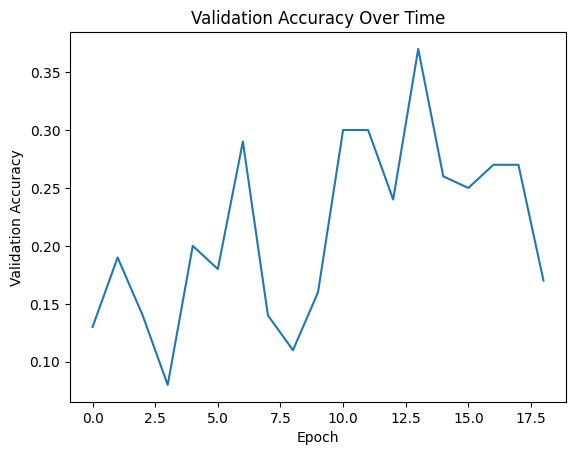

Best Architecture:
Method                      mini-batch
Activation                      Arctan
Hidden Layers                        2
Hidden Size                         32
Best Validation Accuracy          0.67
Test Accuracy                     0.51
Epochs                              38
Training Time (s)             4.933554
Model Updates                      304
Name: 32, dtype: object

Observations:
Did mini-batches help? What observations can you make from the data?
Mini-batches generally yielded better results.
Additional Observations:
The best performing architecture used mini-batch training.


In [ ]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
import time

# Activation Functions
def relu(x, derivative=False):
    if derivative:
        return (x > 0).astype(float)
    return np.maximum(0, x)

def sigmoid(x, derivative=False):
    if derivative:
        return sigmoid(x) * (1 - sigmoid(x))
    return 1 / (1 + np.exp(-x))

def arctan(x, derivative=False):
    if derivative:
        return 1 / (1 + x ** 2)
    return np.arctan(x)

activation_functions = {
    'ReLU': relu,
    'Sigmoid': sigmoid,
    'Arctan': arctan
}

# Load Mini-MNIST data
with open('mini-mnist-1000.pickle', 'rb') as f:
    data = pickle.load(f)

# split data and flatten out the image matrices into feature vectors
train_data, val_data, test_data = data_split(data, 7)
train_data = [(t[0].flatten(), t[1]) for t in train_data]
val_data = [(t[0].flatten(), t[1]) for t in val_data]
test_data = [(t[0].flatten(), t[1]) for t in test_data]

# randomly shuffle the datasets again (training data not getting
# reorganized yet to easily make balanced batches if using minibatch)
random.shuffle(val_data)
random.shuffle(test_data)

# Neural Network Class with Backpropagation
class SimpleNN:
    def __init__(self, input_size, hidden_layers, hidden_size, output_size):
        self.weights = []
        self.biases = []

        # First hidden layer
        self.weights.append(np.random.uniform(-1, 1, (input_size, hidden_size)))
        self.biases.append(np.random.uniform(-1, 1, (hidden_size,)))

        # Additional hidden layers
        for _ in range(hidden_layers - 1):
            self.weights.append(np.random.uniform(-1, 1, (hidden_size,
                                                          hidden_size)))
            self.biases.append(np.random.uniform(-1, 1, (hidden_size,)))

        # Output layer
        self.weights.append(np.random.uniform(-1, 1, (hidden_size,
                                                      output_size)))
        self.biases.append(np.random.uniform(-1, 1, (output_size,)))

    def forward(self, x, activation_func):
        a = x
        for w, b in zip(self.weights[:-1], self.biases[:-1]):
            a = activation_func(np.dot(a, w) + b)

        # Output layer with softmax
        z = np.dot(a, self.weights[-1]) + self.biases[-1]
        return torch.nn.functional.softmax(torch.tensor(z), dim=0)

    def compute_gradients(self, data, activation_func):
        grads = [np.zeros_like(w) for w in self.weights]
        biases_grads = [np.zeros_like(b) for b in self.biases]

        for features, label in data:
            # Forward pass
            activations = [features]

            x = features
            for w, b in zip(self.weights[:-1], self.biases[:-1]):
                x = activation_func(np.dot(x, w) + b)
                activations.append(x)

            # Output layer
            z = np.dot(x, self.weights[-1]) + self.biases[-1]
            output = torch.nn.functional.softmax(torch.tensor(z),
                                                 dim=0).detach().numpy()

            # Backward pass
            delta = output
            delta[label] -= 1

            grads[-1] = np.outer(activations[-2], delta)
            biases_grads[-1] = delta

            # Backpropagation through hidden layers
            for i in range(len(self.weights) - 2, -1, -1):
                derivative = activation_func(activations[i + 1],
                                             derivative=True)
                delta = np.dot(delta, self.weights[i + 1].T) * derivative

                grads[i] = np.outer(activations[i], delta)
                biases_grads[i] = delta.mean(axis=0)

        return grads, biases_grads

    def update_weights(self, grads, biases_grads, learning_rate):
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * grads[i]
            self.biases[i] -= learning_rate * biases_grads[i]

# Accuracy Calculation
def compute_accuracy(model, data, activation_func):
    correct = 0
    for features, label in data:
        output = model.forward(features, activation_func).numpy()
        predicted_label = np.argmax(output)
        if predicted_label == label:
            correct += 1
    return correct / len(data)


# function for generating 8 100-image batches
def get_batches(train_data):
    classes = []
    for i in range(10):
        c = train_data[i*80:(i+1)*80]
        classes.append(c)
    batches = []
    num_batches = 8
    batch_size = 100
    for j in range(num_batches):
        b = []
        for c in classes:
            b1 = c[j*10:(j+1)*10]
            b = b + b1
        random.shuffle(b)
        batches.append(b)
    return batches

# Training Function with Tracking
def train(model, train_data, val_data, learning_rate, activation_func,
          mini_batches, stop_condition):
    best_val_accuracy = 0
    no_improvement = 0
    epoch = 0
    accuracies = []
    model_updates = 0  # To track the number of model updates

    while no_improvement < stop_condition:
        epoch += 1

        if mini_batches:

            batches = get_batches(train_data)
            for batch in batches:
                grads, biases_grads = model.compute_gradients(batch,
                                                              activation_func)
                model.update_weights(grads, biases_grads, learning_rate)
                model_updates += 1
        else:
            random.shuffle(train_data)
            grads, biases_grads = model.compute_gradients(train_data,
                                                          activation_func)
            model.update_weights(grads, biases_grads, learning_rate)
            model_updates += 1

        # Validate accuracy
        val_accuracy = compute_accuracy(model, val_data, activation_func)
        accuracies.append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            no_improvement = 0
        else:
            no_improvement += 1
    return best_val_accuracy, epoch, model_updates, accuracies

# Model parameters
input_size = 7 * 7  # 49-dimensional inputs for 7x7
output_size = 10
learning_rate = 0.02
stop_condition = 5

# Define architectures and training methods as outlined in assignment
# description
architectures = [
    {'hidden_layers': 2, 'hidden_size': 16},
    {'hidden_layers': 2, 'hidden_size': 32},
    {'hidden_layers': 2, 'hidden_size': 64},
    {'hidden_layers': 3, 'hidden_size': 16},
    {'hidden_layers': 3, 'hidden_size': 32},
    {'hidden_layers': 3, 'hidden_size': 64},
    {'hidden_layers': 4, 'hidden_size': 16},
    {'hidden_layers': 4, 'hidden_size': 32},
    {'hidden_layers': 4, 'hidden_size': 64}
]

training_methods = ["full", "mini-batch"]
activation_func_names = ["ReLU", "Sigmoid", "Arctan"]

# Store results
results = []

# Loop through architectures, training methods, and activation functions
for method in training_methods:
    for arch in architectures:
        for act_name in activation_func_names:
            activation_func = activation_functions[act_name]

            # Initialize model
            model = SimpleNN(input_size, arch['hidden_layers'],
                             arch['hidden_size'], output_size)

            # Train the model
            mini_batches = (method == "mini-batch")
            start_time = time.time()  # Track training time
            best_val_accuracy, epochs, model_updates, accuracies = train(
                model, train_data, val_data, learning_rate, activation_func,
                mini_batches, stop_condition
            )
            end_time = time.time()

            training_time = end_time - start_time  # Calculate training time

            # Test accuracy
            test_accuracy = compute_accuracy(model, test_data, activation_func)

            # Record results
            results.append({
                "Method": method,
                "Activation": act_name,
                "Hidden Layers": arch["hidden_layers"],
                "Hidden Size": arch["hidden_size"],
                "Best Validation Accuracy": best_val_accuracy,
                "Test Accuracy": test_accuracy,
                "Epochs": epochs,
                "Training Time (s)": training_time,
                "Model Updates": model_updates
            })

# Create DataFrame for results
results_df = pd.DataFrame(results)
print("Results Table:")
print(results_df)

# Plot validation accuracy over time for one model
plt.plot(accuracies)
plt.title("Validation Accuracy Over Time")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.show()

# Analyzing results
best_result = results_df.loc[results_df["Best Validation Accuracy"].idxmax()]
print("Best Architecture:")
print(best_result)

# Additional insights
print("\nObservations:")
mini_batch_results = results_df[results_df["Method"] == "mini-batch"]
full_batch_results = results_df[results_df["Method"] == "full"]

print("Did mini-batches help? What observations can you make from the data?")
if mini_batch_results["Best Validation Accuracy"].mean() > (
    full_batch_results["Best Validation Accuracy"].mean()):
    print("Mini-batches generally yielded better results.")
else:
    print("Full-batch training generally yielded better results.")

print("Additional Observations:")
if best_result["Method"] == "mini-batch":
    print("The best performing architecture used mini-batch training.")
else:
    print("The best performing architecture used full-batch training.")